CyberTruck

In [ ]:
!pip install torch matplotlib tqdm wget

In [2]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# from nerf_model import TinyNerfModel
# from nerf_dataset import TinyCybertruckDataset, TinyLegoDataset
# from nerf_functions import get_rays, render_rays

In [3]:
# Setting seed because model is sensitive to initialization
seed = 5
torch.manual_seed(seed)

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using device:", torch.cuda.get_device_name(0))
elif torch.backends.mps.is_available():
    # device = torch.device("mps")
    # CPU might be faster for some Mac users
    device = torch.device("cpu")
    print("Using device: Apple Silicon GPU")
else:
    device = torch.device('cpu')
    print("Using device: CPU")

Using device: Tesla T4


#Dataset

In [10]:
import torch
from torch.utils.data import Dataset
import os
import numpy as np
import wget


from google.colab import drive
drive.mount('/content/drive')

# Define the path where you want to save the models
file_path = '/content/drive/MyDrive/2024/Fall 2024/CSCI 5561/cybertruck100_cycles_no_hdri.npz'

class TinyCybertruckDataset(Dataset):
    def __init__(self, split="train"):
        # Set the file path for loading the data
        self.file_name = '/content/drive/MyDrive/2024/Fall 2024/CSCI 5561/cybertruck100_cycles_no_hdri'  # Path to the .npz file
        self.split = split

        # Load data from the specified npz file
        data = np.load(f'{self.file_name}.npz')
        self.images = data["images"]
        self.poses = data["poses"]
        self.focal = data["focal"]

        # Split data into training and testing sets
        self.images = self.images[:-1] if split == "train" else self.images[-1:]
        self.poses = self.poses[:-1] if split == "train" else self.poses[-1:]

        print(f"Dataset loaded successfully. Dataset details:")
        print(f"Images shape: {self.images.shape}")
        print(f"Poses shape: {self.poses.shape}")
        print(f"Focal length: {self.focal}")

        # Optionally, visualize a sample image and its corresponding pose
        sample_image = self.images[0]
        sample_pose = self.poses[0]
        plt.imshow(sample_image)
        plt.show()
        print("Sample pose for the image:")
        print(sample_pose)

    def get_near_far(self):
        return 3, 7

    def get_image_size(self):
        first_img = self.images[0]
        return first_img.shape[0], first_img.shape[1]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return (torch.tensor(self.images[index], dtype=torch.float32),
                torch.tensor(self.poses[index], dtype=torch.float32),
                torch.tensor(self.focal, dtype=torch.float32),)


class TinyLegoDataset(Dataset):
    def __init__(self, split="train"):
        if not os.path.exists('tiny_nerf_data.npz'):
            url = 'http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz'
            wget.download(url, 'tiny_nerf_data.npz')

        self.split = split

        data = np.load('tiny_nerf_data.npz')
        images = data["images"]
        poses = data["poses"]
        focal = data["focal"]

        self.images = images[:-1] if split == "train" else images[-1:]
        self.poses = poses[:-1] if split == "train" else poses[-1:]
        self.focal = focal

    def get_near_far(self):
        return 2, 6

    def get_image_size(self):
        first_img = self.images[0]
        return first_img.shape[0], first_img.shape[1]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return (torch.tensor(self.images[index], dtype=torch.float32),
                torch.tensor(self.poses[index], dtype=torch.float32),
                torch.tensor(self.focal, dtype=torch.float32),)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Functions

In [7]:
import torch

def get_rays(H, W, focal, c2w, device="cuda"):
    """
    This function generates rays that pass through each pixel of the image, starting at the camera origin.

    H: int, Height of the image
    W: int, Width of the image
    focal: float, Focal length of the camera
    c2w: torch.Tensor of shape (4, 4), Camera to world matrix
    device: str, Device to use
    returns: rays_o -> (H, W, 3), rays_d -> (H, W, 3)
    """

    i, j = torch.meshgrid(torch.arange(0, W), torch.arange(0, H), indexing='xy')
    i, j = i.to(device), j.to(device)

    dirs = torch.stack([(i - W / 2)/focal, -(j - H / 2)/focal, -torch.ones_like(i)], -1).to(device)
    dirs /= torch.norm(dirs, dim=-1, keepdim=True)

    # broadcasting c2w to shape (H, W, 3, 3) and multiplying with dirs of shape (H, W, 3, 1)
    # Result is a tensor of shape (H, W, 3, 1), which is why we need to squeeze the last dimension
    # Direction vectors stay relative to local origin, which is why we're not translating them
    rays_d = torch.broadcast_to(c2w[:3,:3], (H, W, 3, 3)) @ dirs[..., None]
    rays_d = rays_d.squeeze()

    rays_o = torch.broadcast_to(c2w[:3,-1], rays_d.shape)
    return rays_o, rays_d



def render_rays(model, rays_o, rays_d, near, far, N_samples, device="cuda"):
    """
    This function renders the rays using the NeRF model & volume rendering.

    model: nn.Module, NeRF model
    rays_o: torch.Tensor of shape (H, W, 3), Origin of the rays
    rays_d: torch.Tensor of shape (H, W, 3), Direction of the rays
    near: float, Near plane
    far: float, Far plane
    N_samples: int, Number of samples to take along each ray
    device: str, Device to use
    returns: rgb_map -> (H, W, 3), Rendered image
    """
    z_vals = torch.linspace(near, far, N_samples + 1)[:-1].to(device)
    z_vals = torch.broadcast_to(z_vals, list(rays_o.shape[:-1]) + [N_samples]).clone()

    z_vals += torch.rand_like(z_vals) * (far - near) / N_samples

    # rays_o and rays_d are of shape (H, W, 3)
    # z_vals is of shape (H, W, N_samples)
    # (H, W, 1, 3) + (H, W, 1, 3) * (H, W, N_samples, 1) -> (H, W, N_samples, 3)
    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., None]

    rgb, sigma = model(pts)

    buffer = torch.broadcast_to(torch.tensor([1e10]).to(device), z_vals[...,:1].shape)
    dists = torch.concat([z_vals[..., 1:] - z_vals[..., :-1], buffer], -1)

    alpha = 1. - torch.exp(-sigma * dists)

    # e^{a + b} = e^a * e^b
    cumprod = torch.cumprod(1 - alpha + 1e-10, -1)
    exclusive_cumprod = torch.cat([torch.broadcast_to(torch.tensor([1.]).to(device), cumprod[...,:1].shape), cumprod[...,:-1]], -1)
    weights = alpha * exclusive_cumprod

    rgb_map = torch.sum(weights[..., None] * rgb, -2)
    return rgb_map

#NeRF Model - TinyNeRF

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class TinyNerfModel(nn.Module):
    def __init__(self, W=256):
        super().__init__()

        input_size = 3

        self.block1 = nn.Sequential(
            nn.Linear(input_size, W),
            nn.ReLU(),

            nn.Linear(W, W),
            nn.ReLU(),

            nn.Linear(W, W),
            nn.ReLU(),

            nn.Linear(W, W),
            nn.ReLU(),
        )

        self.block2 = nn.Sequential(
            nn.Linear(W + input_size, W),
            nn.ReLU(),

            nn.Linear(W, W),
            nn.ReLU(),

            nn.Linear(W, W),
            nn.ReLU(),

            nn.Linear(W, W),
            nn.ReLU(),

            nn.Linear(W, 4),
        )


    def forward(self, inputs):
        """
            inputs: (batch_dim, 3)
            returns: RGB -> (batch_dim, 3), Sigma -> (batch_dim, 1)
        """
        a = self.block1(inputs)
        b = self.block2(torch.cat([a, inputs], dim=-1))
        return  F.sigmoid(b[..., :3]), F.relu(b[...,3])

#Main Pipeline

Dataset loaded successfully. Dataset details:
Images shape: (105, 100, 100, 3)
Poses shape: (105, 4, 4)
Focal length: 138.88887889922103


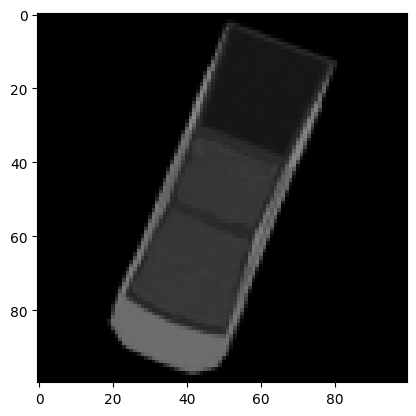

Sample pose for the image:
[[ 9.3203241e-01 -3.6066559e-01  3.5155509e-02  1.7577715e-01]
 [ 3.6237493e-01  9.2763603e-01 -9.0420254e-02 -4.5210087e-01]
 [-3.9072670e-08  9.7014084e-02  9.9528301e-01  4.9764152e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
Dataset loaded successfully. Dataset details:
Images shape: (1, 100, 100, 3)
Poses shape: (1, 4, 4)
Focal length: 138.88887889922103


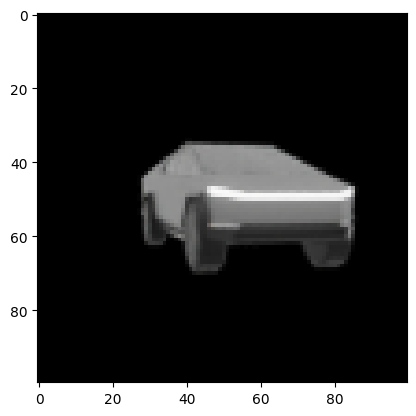

Sample pose for the image:
[[ 9.5595139e-01  1.3845247e-03 -2.9352173e-01 -1.4676083e+00]
 [-2.9352498e-01  4.5090360e-03 -9.5594078e-01 -4.7797041e+00]
 [-2.3597792e-08  9.9998885e-01  4.7168122e-03  2.3584906e-02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


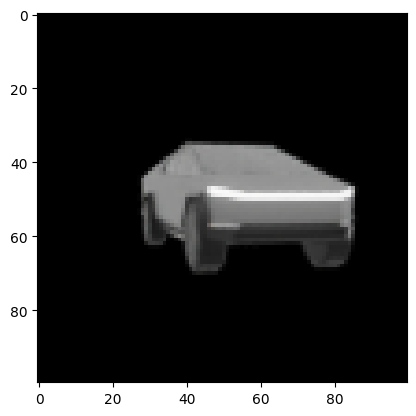

In [11]:

train_data = TinyCybertruckDataset()
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)

testimg, testpose, testfocal = TinyCybertruckDataset(split='test')[0]
testpose = testpose.to(device)

plt.imshow(testimg)
plt.show()

In [12]:
model = TinyNerfModel()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
loss_fn = torch.nn.MSELoss()

In [13]:
# Using Xavier initialization because model performs better (found out through trial and error)
# https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.xavier_uniform_
for m in model.modules():
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.zeros_(m.bias)

In [14]:
model = model.to(device)

Epoch 0


100%|██████████| 105/105 [00:55<00:00,  1.88it/s]


Epoch took 55.99214553833008 seconds, Loss: 0.0036332367453724146


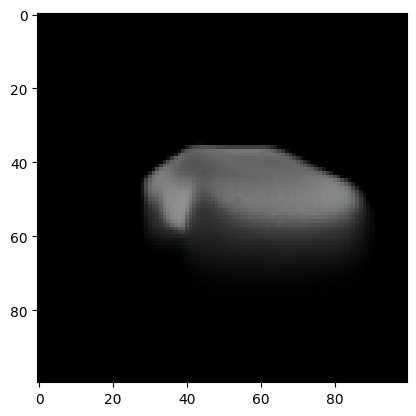

Epoch 1


100%|██████████| 105/105 [00:57<00:00,  1.82it/s]


Epoch took 57.72961974143982 seconds, Loss: 0.003360934555530548


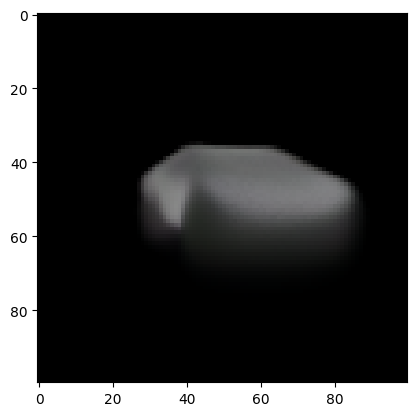

Epoch 2


100%|██████████| 105/105 [00:59<00:00,  1.78it/s]


Epoch took 59.020068407058716 seconds, Loss: 0.002937299432232976


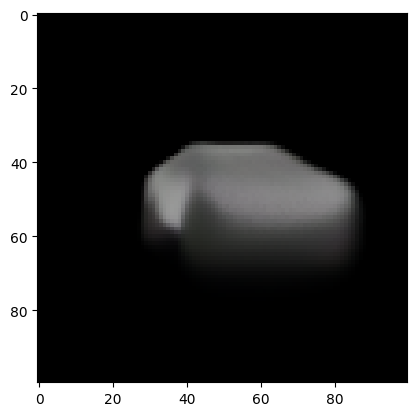

Epoch 3


100%|██████████| 105/105 [00:59<00:00,  1.75it/s]


Epoch took 59.93156886100769 seconds, Loss: 0.0033475819509476423


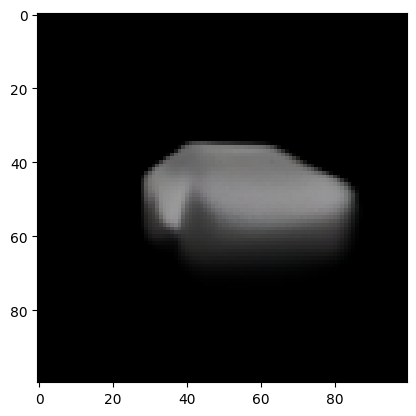

Epoch 4


100%|██████████| 105/105 [01:00<00:00,  1.73it/s]


Epoch took 60.78496479988098 seconds, Loss: 0.0032528075389564037


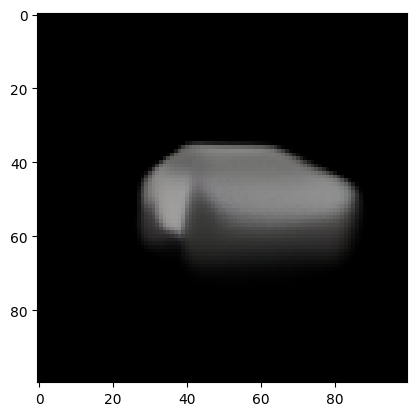

Epoch 5


100%|██████████| 105/105 [01:01<00:00,  1.72it/s]


Epoch took 61.16241002082825 seconds, Loss: 0.004351628478616476


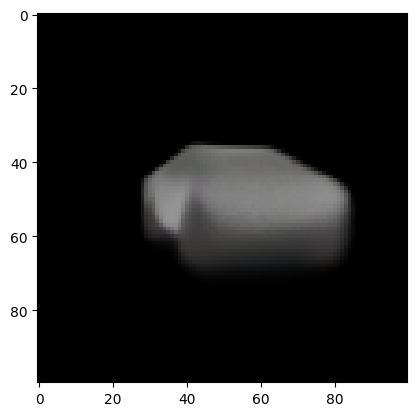

Epoch 6


100%|██████████| 105/105 [01:01<00:00,  1.71it/s]


Epoch took 61.30107855796814 seconds, Loss: 0.003249535569921136


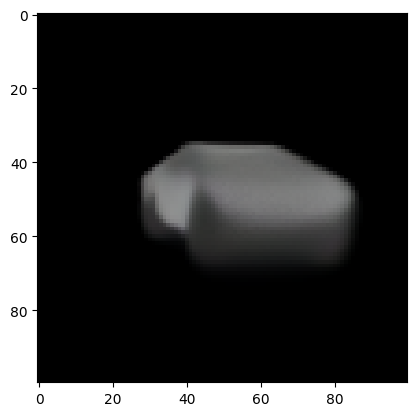

Epoch 7


100%|██████████| 105/105 [01:01<00:00,  1.71it/s]


Epoch took 61.377328395843506 seconds, Loss: 0.0038493124302476645


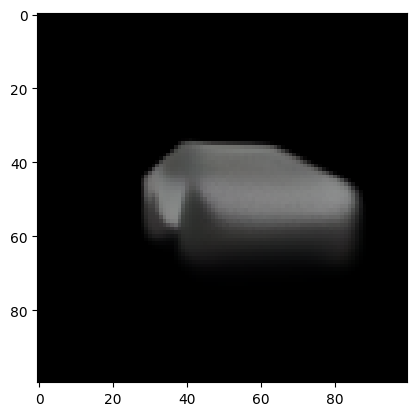

Epoch 8


100%|██████████| 105/105 [01:01<00:00,  1.71it/s]


Epoch took 61.29657459259033 seconds, Loss: 0.0021588713862001896


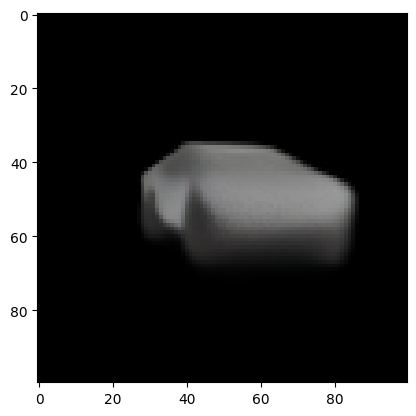

Epoch 9


100%|██████████| 105/105 [01:01<00:00,  1.72it/s]


Epoch took 61.21902275085449 seconds, Loss: 0.0014449162408709526


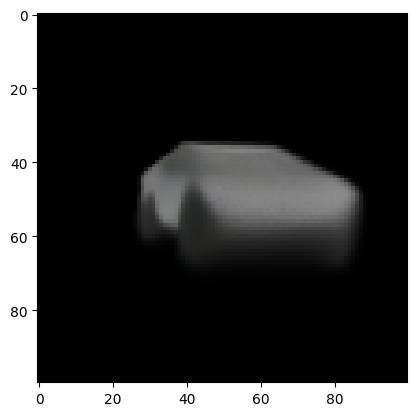

Epoch 10


100%|██████████| 105/105 [01:01<00:00,  1.71it/s]


Epoch took 61.31359624862671 seconds, Loss: 0.002565927803516388


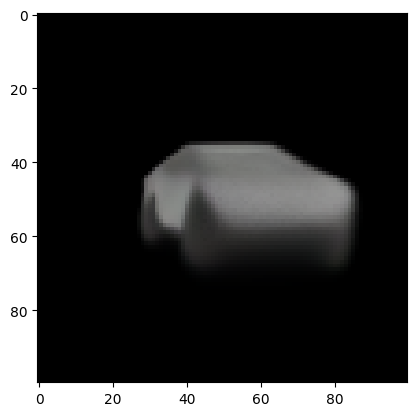

Epoch 11


100%|██████████| 105/105 [01:01<00:00,  1.71it/s]


Epoch took 61.41737484931946 seconds, Loss: 0.002125320490449667


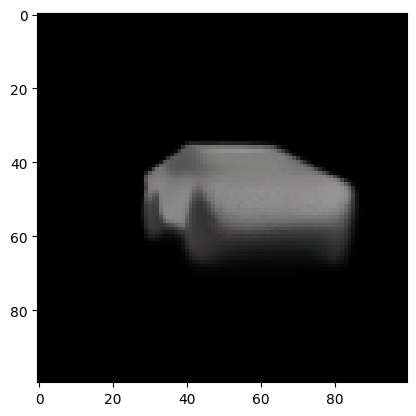

Epoch 12


100%|██████████| 105/105 [01:01<00:00,  1.71it/s]


Epoch took 61.44212794303894 seconds, Loss: 0.0026312568224966526


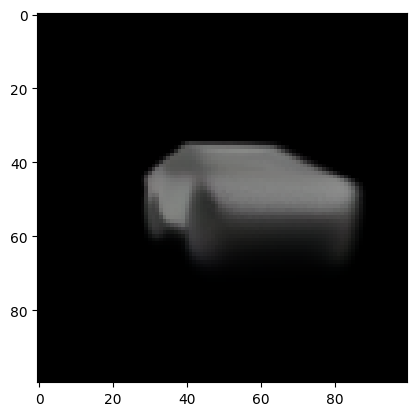

Epoch 13


100%|██████████| 105/105 [01:01<00:00,  1.71it/s]


Epoch took 61.46511149406433 seconds, Loss: 0.0018137276638299227


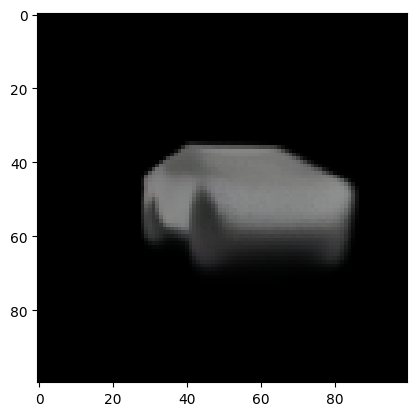

Epoch 14


100%|██████████| 105/105 [01:01<00:00,  1.71it/s]


Epoch took 61.37640309333801 seconds, Loss: 0.0017641527811065316


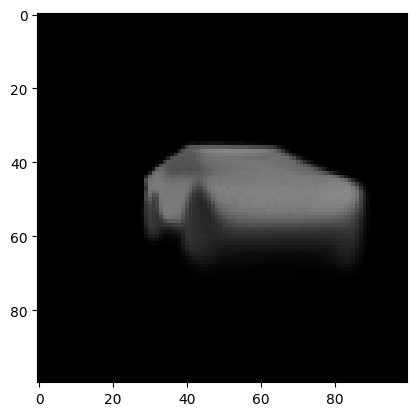

Epoch 15


100%|██████████| 105/105 [01:01<00:00,  1.71it/s]


Epoch took 61.41850471496582 seconds, Loss: 0.0019061450148001313


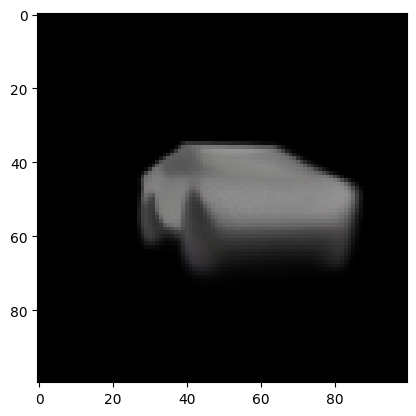

Epoch 16


100%|██████████| 105/105 [01:01<00:00,  1.71it/s]


Epoch took 61.41320991516113 seconds, Loss: 0.002581868087872863


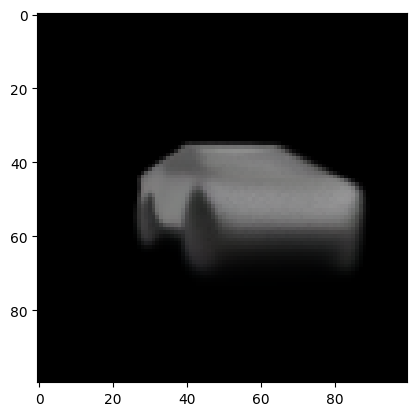

Epoch 17


100%|██████████| 105/105 [01:01<00:00,  1.71it/s]


Epoch took 61.33919668197632 seconds, Loss: 0.0014938084641471505


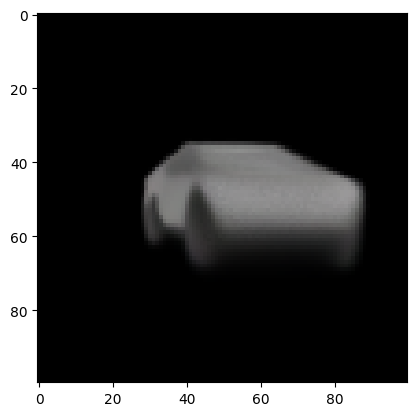

Epoch 18


100%|██████████| 105/105 [01:01<00:00,  1.71it/s]


Epoch took 61.34142279624939 seconds, Loss: 0.0032632038928568363


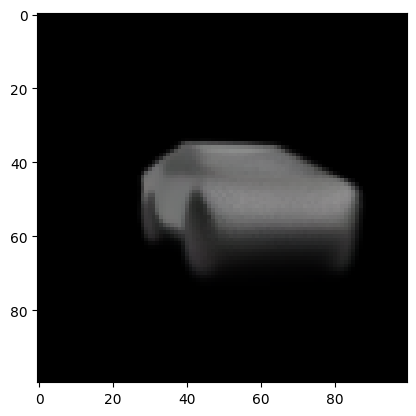

Epoch 19


100%|██████████| 105/105 [01:01<00:00,  1.71it/s]


Epoch took 61.32144212722778 seconds, Loss: 0.0019613588228821754


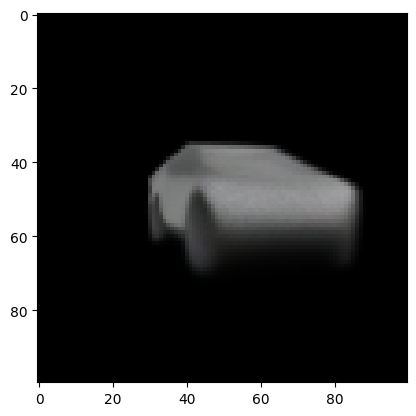

Epoch 20


100%|██████████| 105/105 [01:01<00:00,  1.71it/s]


Epoch took 61.295594215393066 seconds, Loss: 0.0029040768276900053


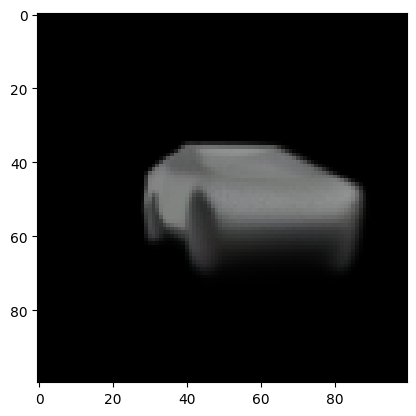

Epoch 21


100%|██████████| 105/105 [01:01<00:00,  1.71it/s]


Epoch took 61.28077721595764 seconds, Loss: 0.0015503558097407222


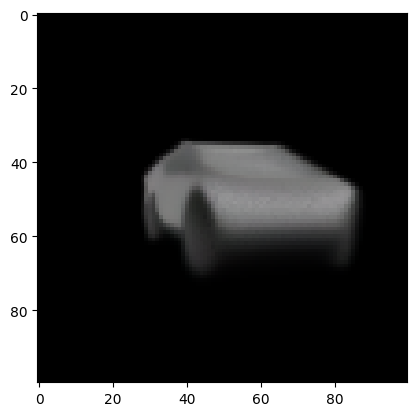

Epoch 22


100%|██████████| 105/105 [01:01<00:00,  1.71it/s]


Epoch took 61.329697608947754 seconds, Loss: 0.0015381379052996635


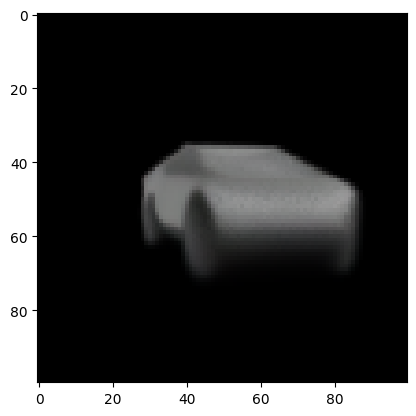

Epoch 23


100%|██████████| 105/105 [01:01<00:00,  1.71it/s]


Epoch took 61.312357664108276 seconds, Loss: 0.0024626594968140125


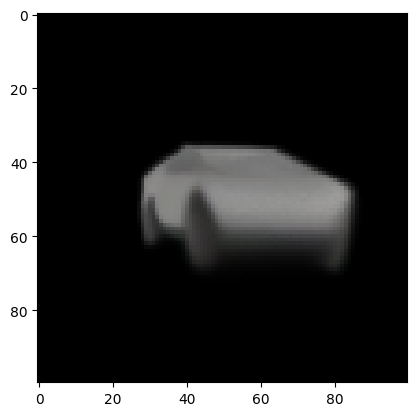

Epoch 24


100%|██████████| 105/105 [01:01<00:00,  1.72it/s]


Epoch took 61.218140602111816 seconds, Loss: 0.0034612384624779224


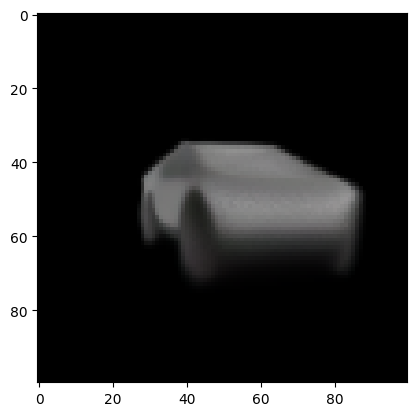

Epoch 25


100%|██████████| 105/105 [01:01<00:00,  1.71it/s]


Epoch took 61.24597907066345 seconds, Loss: 0.002133437665179372


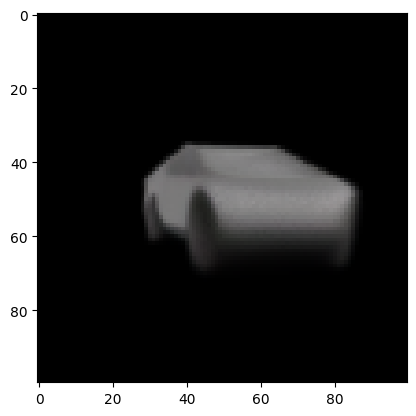

Epoch 26


100%|██████████| 105/105 [01:01<00:00,  1.72it/s]


Epoch took 61.16748404502869 seconds, Loss: 0.0013263270957395434


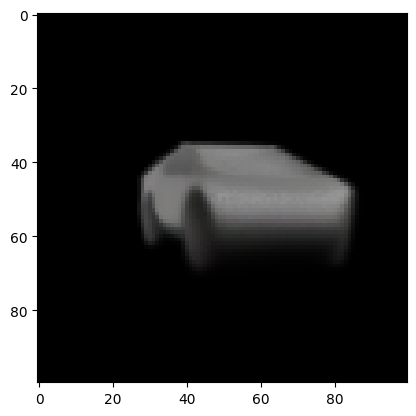

Epoch 27


100%|██████████| 105/105 [01:01<00:00,  1.72it/s]


Epoch took 61.159855365753174 seconds, Loss: 0.0025777623523026705


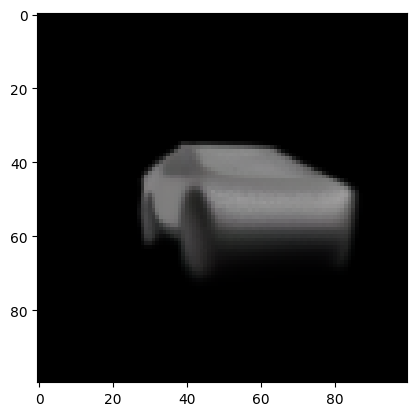

Epoch 28


100%|██████████| 105/105 [01:01<00:00,  1.72it/s]


Epoch took 61.08702516555786 seconds, Loss: 0.0014639903092756867


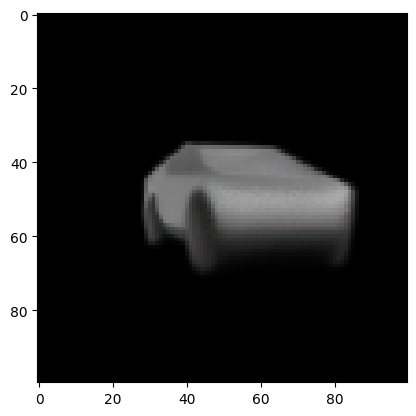

Epoch 29


100%|██████████| 105/105 [01:01<00:00,  1.72it/s]


Epoch took 61.16523361206055 seconds, Loss: 0.0023346326779574156


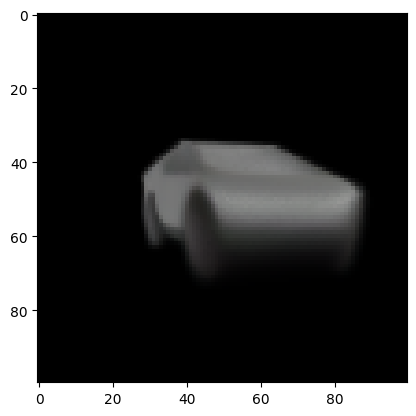

Epoch 30


100%|██████████| 105/105 [01:01<00:00,  1.72it/s]


Epoch took 61.195584535598755 seconds, Loss: 0.0016283101867884398


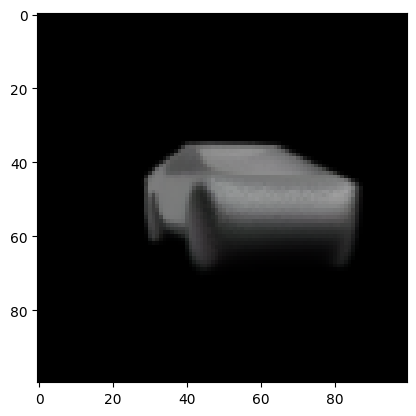

Epoch 31


100%|██████████| 105/105 [01:01<00:00,  1.71it/s]


Epoch took 61.280006885528564 seconds, Loss: 0.0032036982011049986


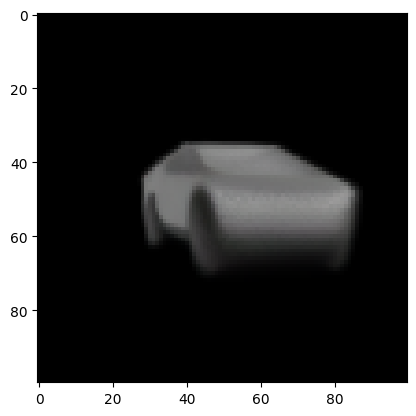

Epoch 32


100%|██████████| 105/105 [01:01<00:00,  1.71it/s]


Epoch took 61.2356960773468 seconds, Loss: 0.0027682322543114424


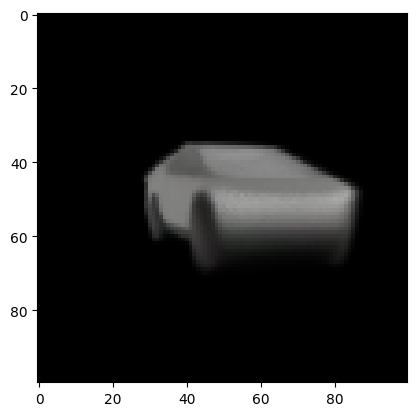

Epoch 33


100%|██████████| 105/105 [01:01<00:00,  1.71it/s]


Epoch took 61.24328017234802 seconds, Loss: 0.0018010938074439764


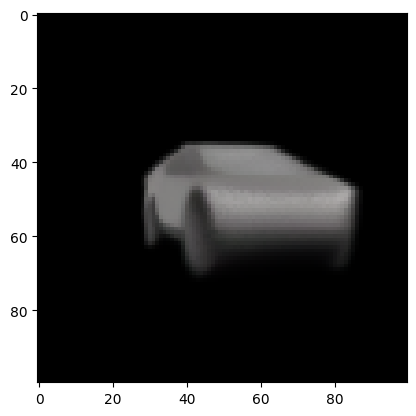

Epoch 34


100%|██████████| 105/105 [01:01<00:00,  1.72it/s]


Epoch took 61.172260999679565 seconds, Loss: 0.002469139639288187


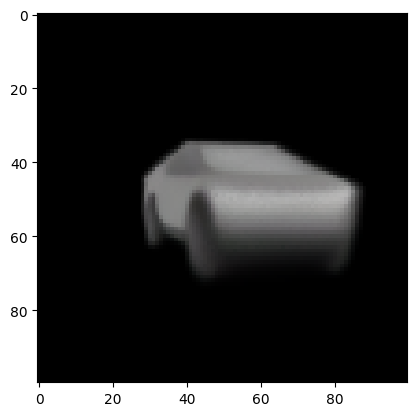

Epoch 35


100%|██████████| 105/105 [01:01<00:00,  1.71it/s]


Epoch took 61.28140735626221 seconds, Loss: 0.002755826571956277


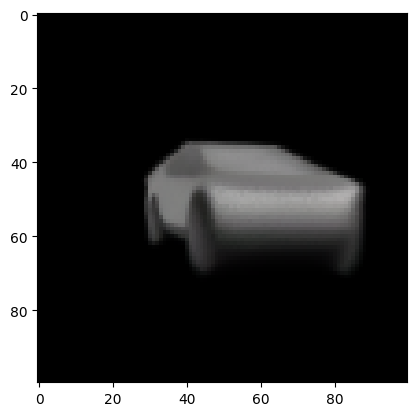

Epoch 36


100%|██████████| 105/105 [01:01<00:00,  1.72it/s]


Epoch took 61.22091865539551 seconds, Loss: 0.001403000671416521


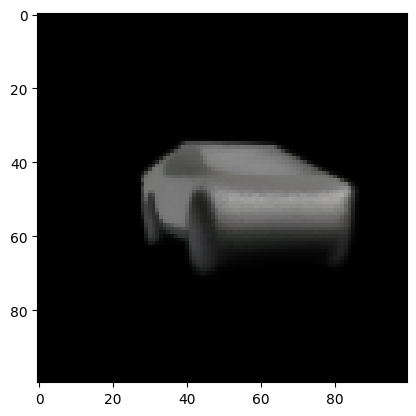

Epoch 37


100%|██████████| 105/105 [01:01<00:00,  1.72it/s]


Epoch took 61.12583518028259 seconds, Loss: 0.0015089409425854683


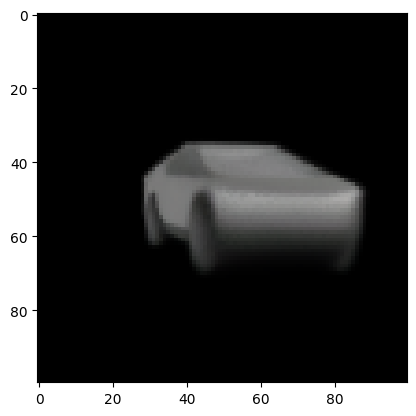

Epoch 38


100%|██████████| 105/105 [01:01<00:00,  1.72it/s]


Epoch took 61.1244535446167 seconds, Loss: 0.0017060897080227733


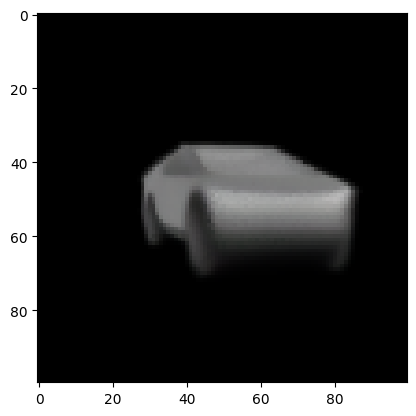

Epoch 39


100%|██████████| 105/105 [01:01<00:00,  1.72it/s]


Epoch took 61.109426498413086 seconds, Loss: 0.0018084438052028418


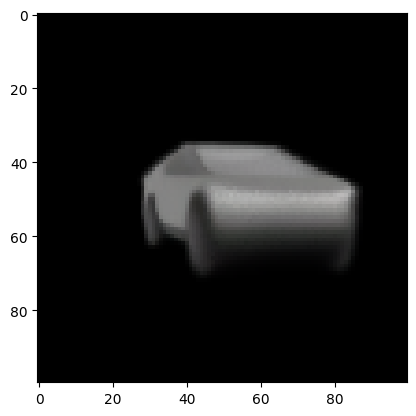

Epoch 40


100%|██████████| 105/105 [01:01<00:00,  1.72it/s]


Epoch took 61.20832324028015 seconds, Loss: 0.0014188311761245131


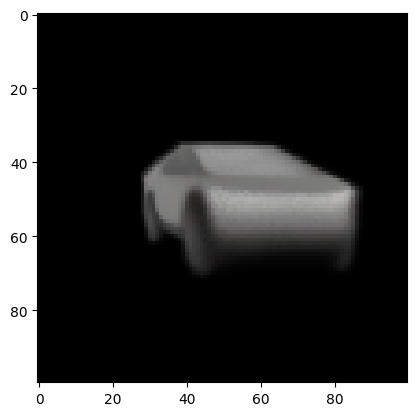

Epoch 41


100%|██████████| 105/105 [01:01<00:00,  1.72it/s]


Epoch took 61.17948365211487 seconds, Loss: 0.0023005676921457052


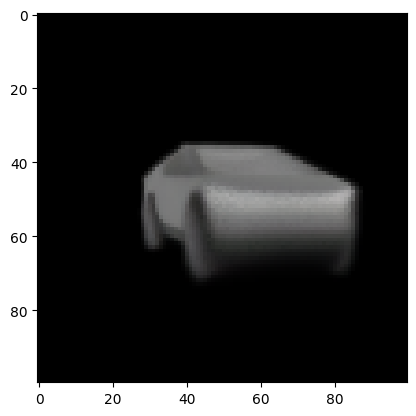

Epoch 42


100%|██████████| 105/105 [01:01<00:00,  1.72it/s]


Epoch took 61.06932091712952 seconds, Loss: 0.000998229836113751


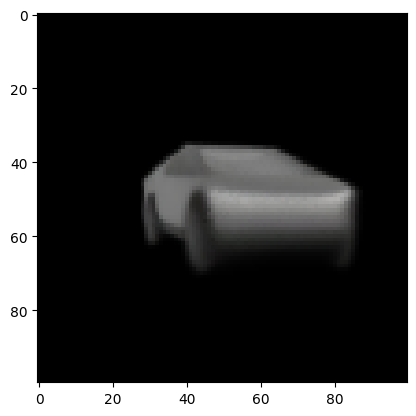

Epoch 43


100%|██████████| 105/105 [01:00<00:00,  1.72it/s]


Epoch took 60.924684047698975 seconds, Loss: 0.0014255044516175985


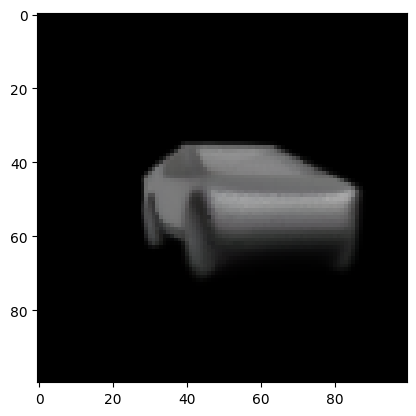

Epoch 44


100%|██████████| 105/105 [01:00<00:00,  1.72it/s]


Epoch took 60.91584849357605 seconds, Loss: 0.0014372721780091524


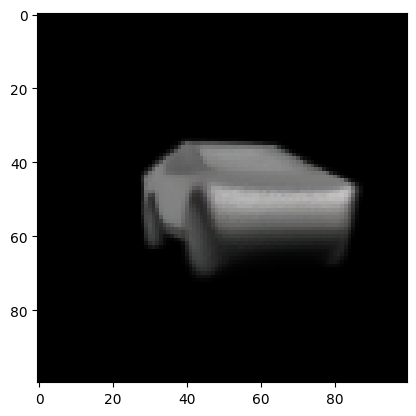

Epoch 45


100%|██████████| 105/105 [01:01<00:00,  1.72it/s]


Epoch took 61.05254602432251 seconds, Loss: 0.0017592364456504583


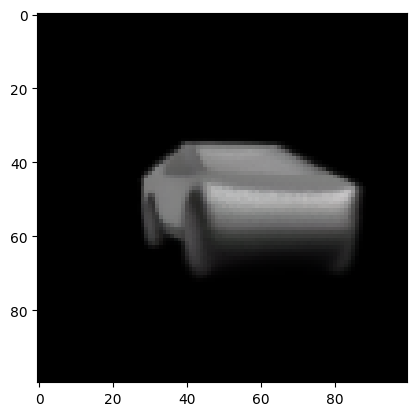

Epoch 46


100%|██████████| 105/105 [01:01<00:00,  1.72it/s]


Epoch took 61.030884742736816 seconds, Loss: 0.0018859074916690588


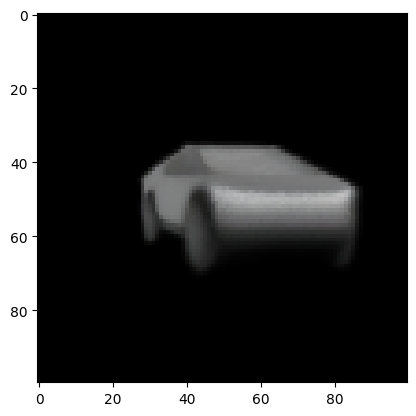

Epoch 47


100%|██████████| 105/105 [01:00<00:00,  1.72it/s]


Epoch took 60.98831653594971 seconds, Loss: 0.0013067611726000905


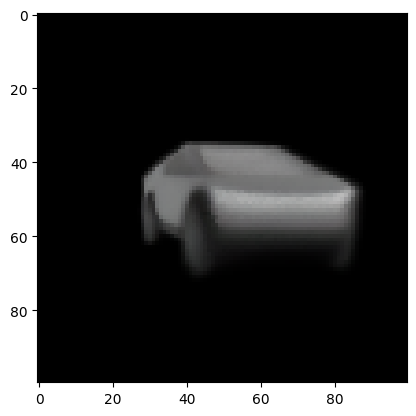

Epoch 48


100%|██████████| 105/105 [01:00<00:00,  1.72it/s]


Epoch took 60.99423623085022 seconds, Loss: 0.0018186902161687613


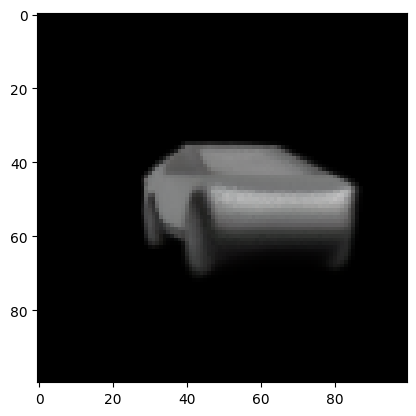

Epoch 49


100%|██████████| 105/105 [01:00<00:00,  1.72it/s]


Epoch took 60.9753201007843 seconds, Loss: 0.0011636357521638274


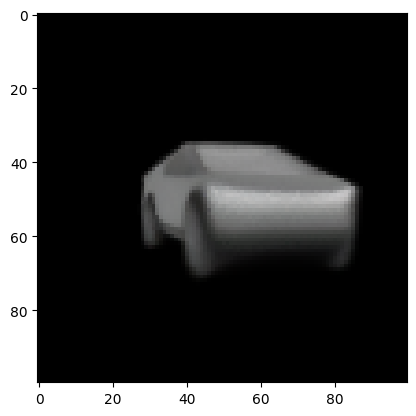

In [16]:
NUM_EPOCHS = 50
near, far = train_data.get_near_far()
H, W = train_data.get_image_size()
N_samples = 64


for i in range(NUM_EPOCHS):
    print(f"Epoch {i}")
    start_time = time.time()

    for target_image, pose, focal in tqdm(train_dataloader):
        target_image = target_image.to(device)
        pose = pose.squeeze().to(device)
        focal = focal.to(device)

        rays_o, rays_d = get_rays(H, W, focal, pose, device=device)
        rgb_map = render_rays(model, rays_o, rays_d, near, far, N_samples, device=device)

        loss = loss_fn(rgb_map, target_image.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch took {time.time() - start_time} seconds, Loss: {loss.item()}")
    with torch.no_grad():
        rays_o, rays_d = get_rays(H, W, testfocal, testpose, device=device)
        rgb = render_rays(model, rays_o, rays_d, near, far, N_samples, device=device)
        plt.imshow(rgb.cpu().numpy())
        plt.show()

